In [1]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn import preprocessing
import seaborn as sns

In [2]:
import sklearn

import numpy as np
import pandas as pd

# Spis Treści
1. Metoda K-średnich (powtórzenie)
2. DBSCAN
3. GMM
4. Standaryzacja

Przygotowanie danych:

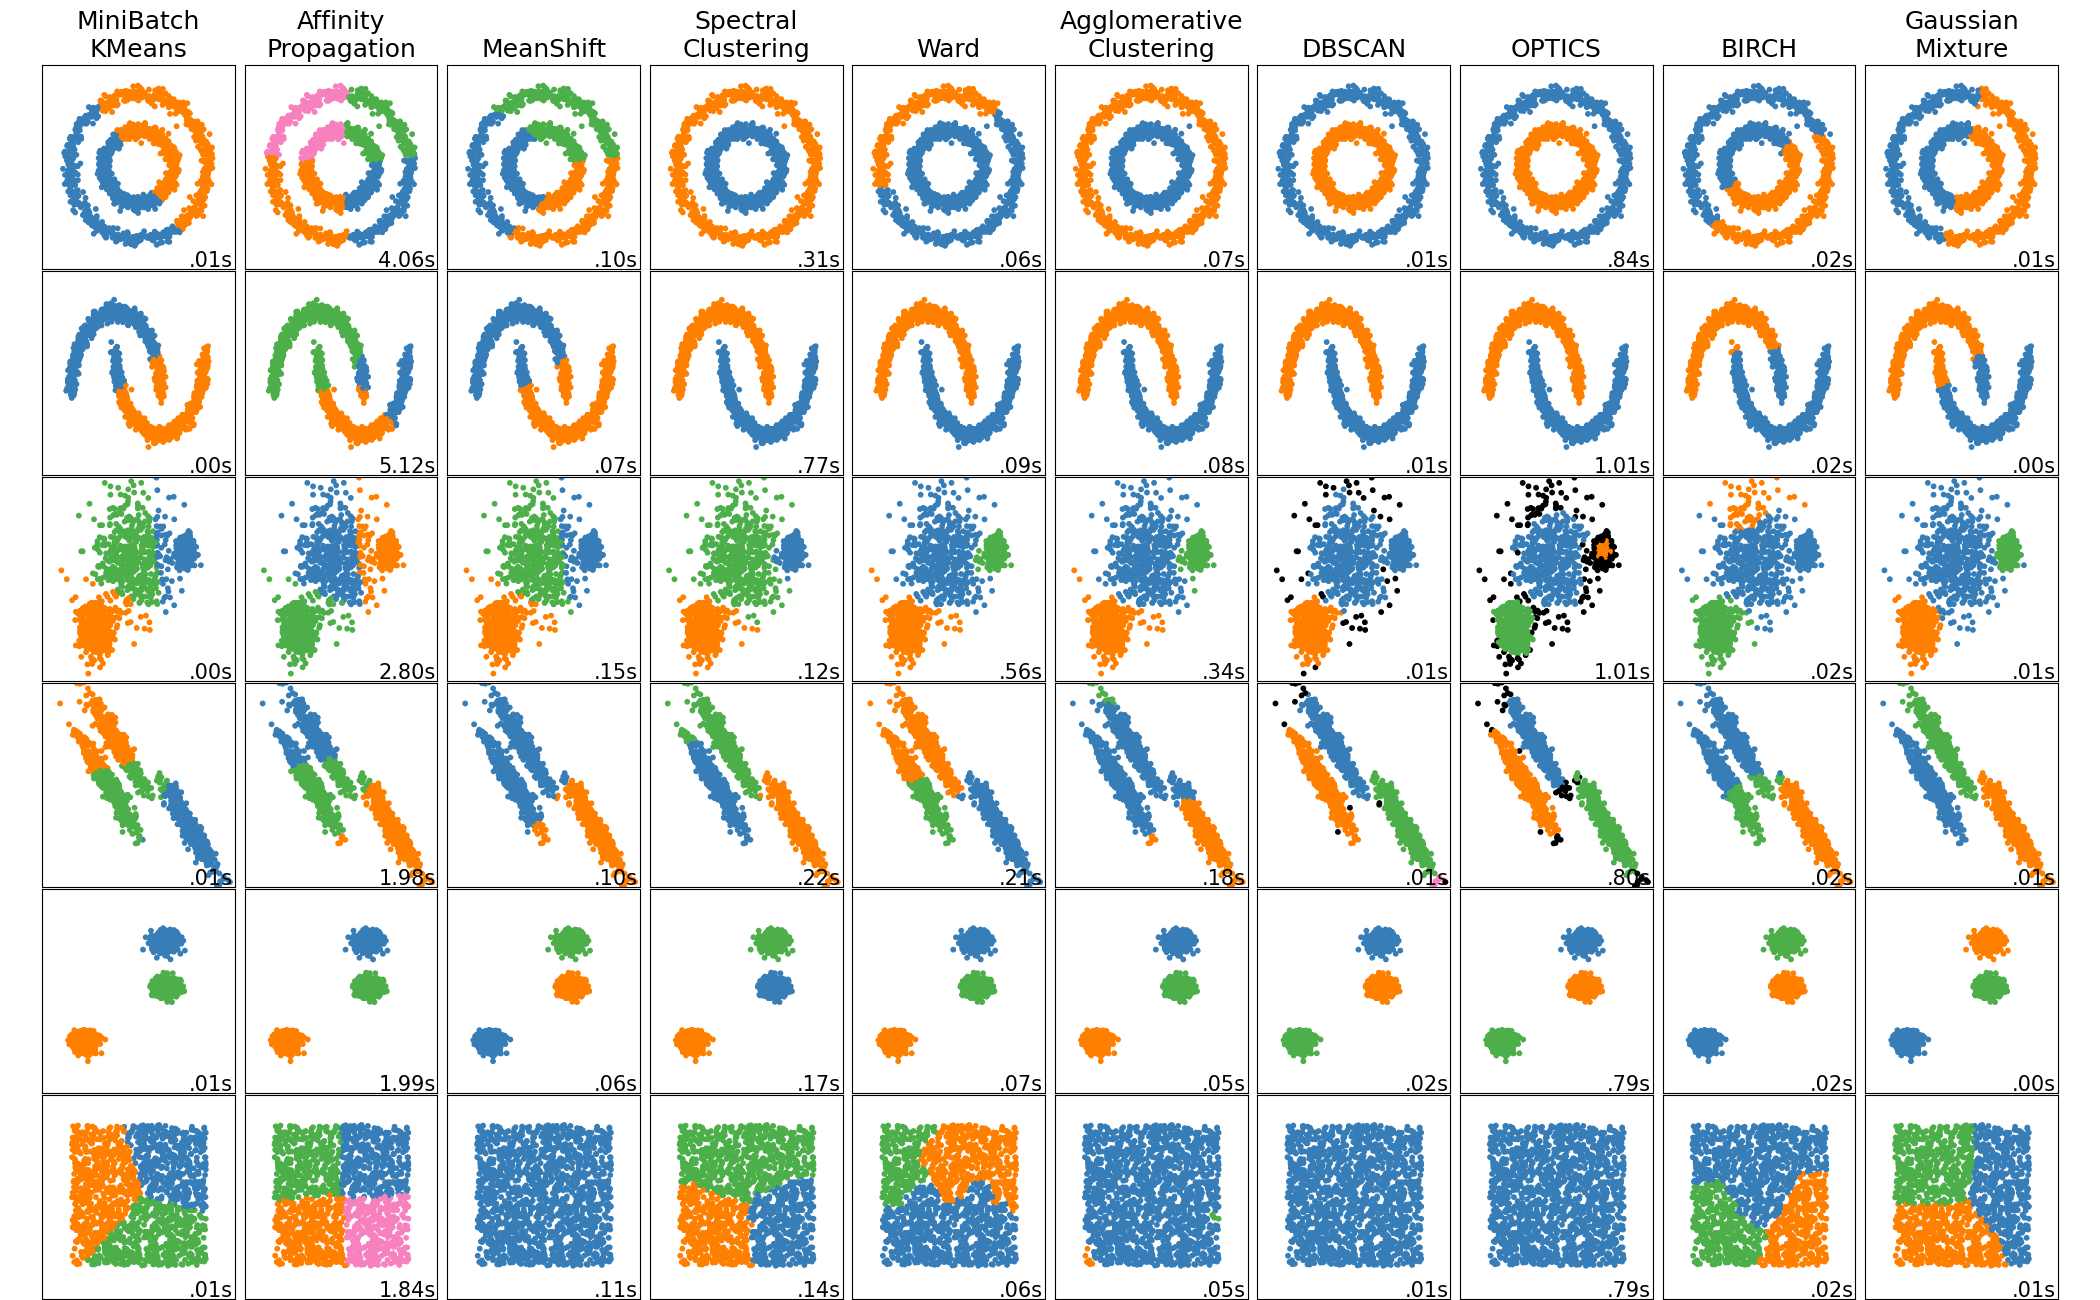

źródło: https://scikit-learn.org/stable/modules/clustering.html

In [3]:
# Przygotowanie danych
n_samples = 1500
noisy_circles, _ = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs, _ = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
X, _ = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, _)

X, _ = datasets.make_blobs(n_samples=n_samples, random_state=1)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso_noisy = np.dot(X, transformation)
aniso_noisy = (X_aniso, _)

varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=170)

X_batch_blobs, y_batch_blobs= datasets.make_blobs(n_samples=np.linspace(1000, 21000, 11, dtype=int),
                                                  random_state=8, center_box=(-100, 100),
                                                  cluster_std=np.linspace(1, 5, 11))

noisy_circles


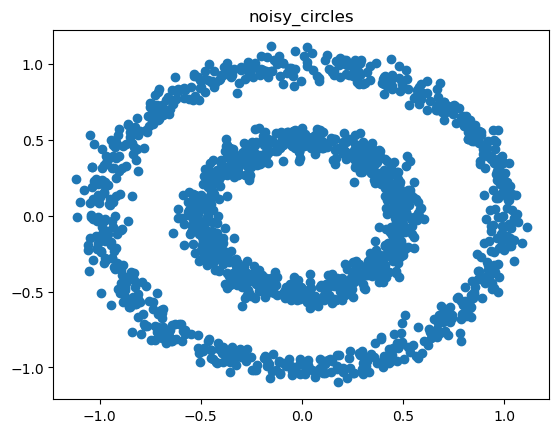

noisy_moons


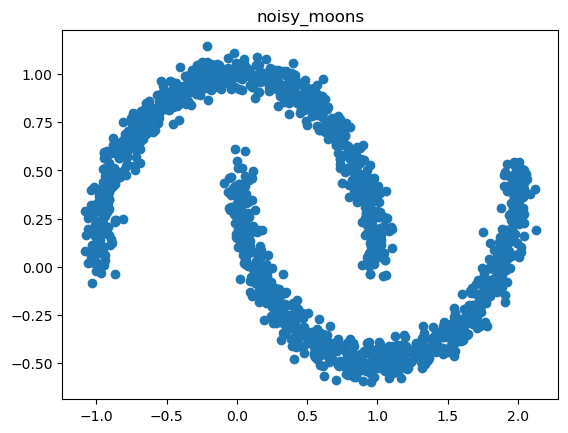

blobs


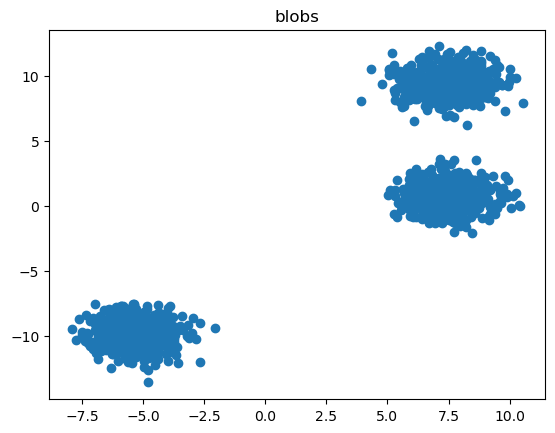

no_structure


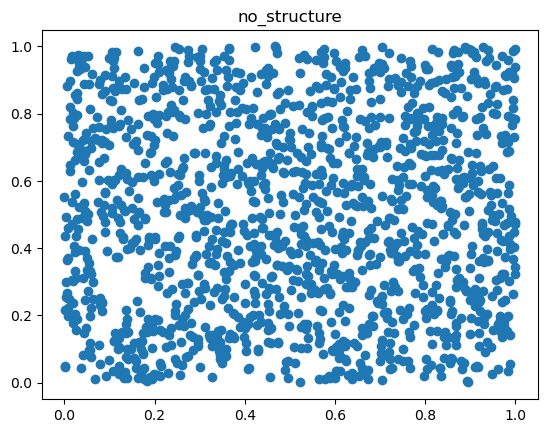

aniso


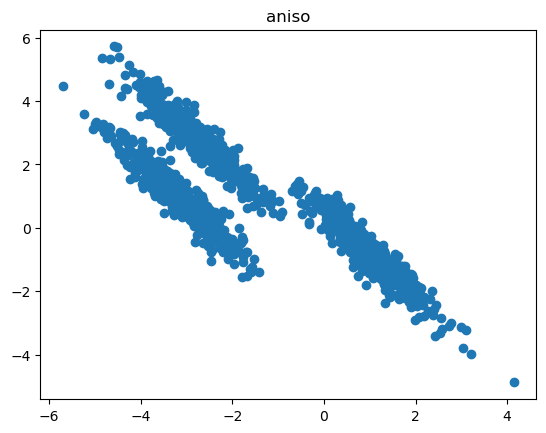

aniso_noisy


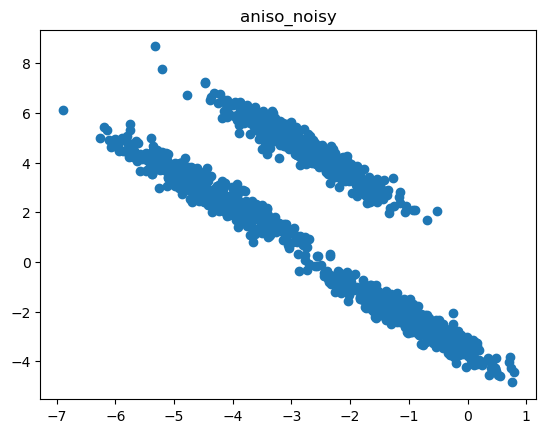

varied


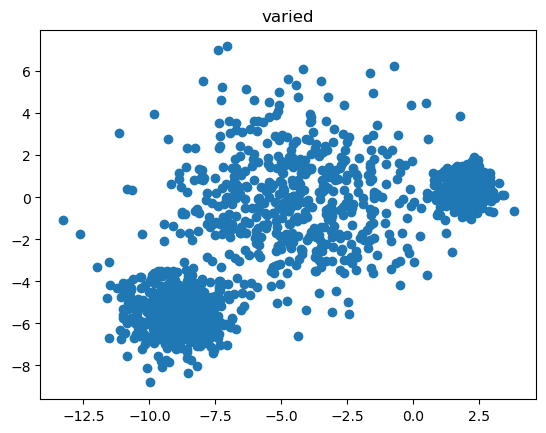

X_batch_blobs


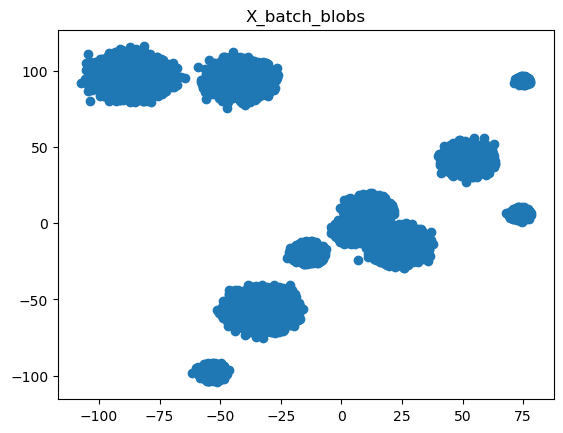

In [4]:
list_datasets = [noisy_circles, noisy_moons, blobs, no_structure[0], X_aniso, X_aniso_noisy, varied[0], X_batch_blobs]
list_title = ["noisy_circles", "noisy_moons", "blobs", "no_structure", "aniso", "aniso_noisy", "varied", "X_batch_blobs"]
k = 0
for k in range(len(list_datasets)):
    print(list_title[k])
    plt.scatter(list_datasets[k][:, 0], list_datasets[k][:, 1])
    plt.title(list_title[k])
    plt.show()

## Metoda K-średnich <a name="kmeans"></a>




Przypomnienie:  
![](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif)
<div align="center">Żródło: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68</div>

**Zalety?**
- niska złożoność, a co za tym idzie wysoka wydajność działania,
- działa szybko przy dużych zbiorach i niskich ilościach grup,
- pogrupowane zbiory są z reguły bardziej ciaśniejsze i zbite.

**Wady?**
- nie pomaga w określeniu ilości grup (K),
- różne wartości początkowe prowadzą do różnych wyników,
- działa dobrze tylko dla „sferycznych” skupisk o jednorodnej gęstości.

**Pytania – co można poprawić?**
- Co zrobić jeśli mamy bardzo dużo danych?
- Co jeśli dane nie są sferyczne?
- Może automatyczna detekcja liczby skupień?


## Optymalna liczba klastrów dla k-Means

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

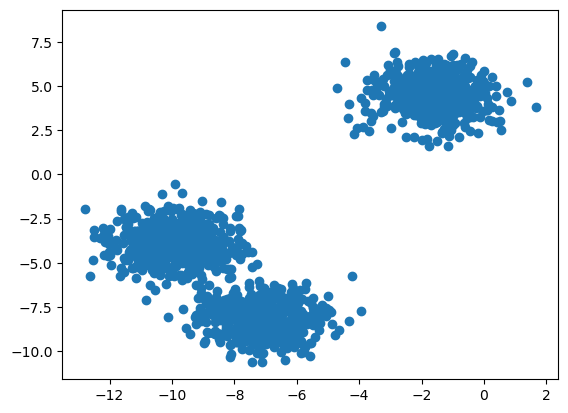

In [6]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [7]:
def metrics_plots(max_k=10):

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

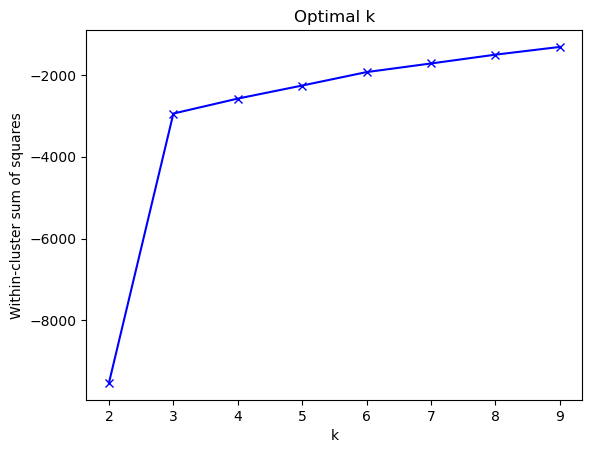

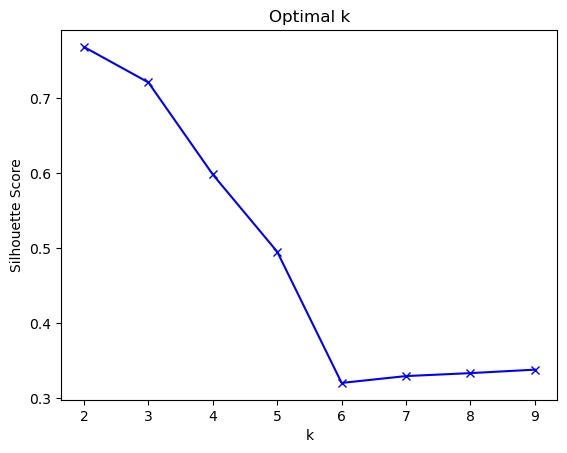

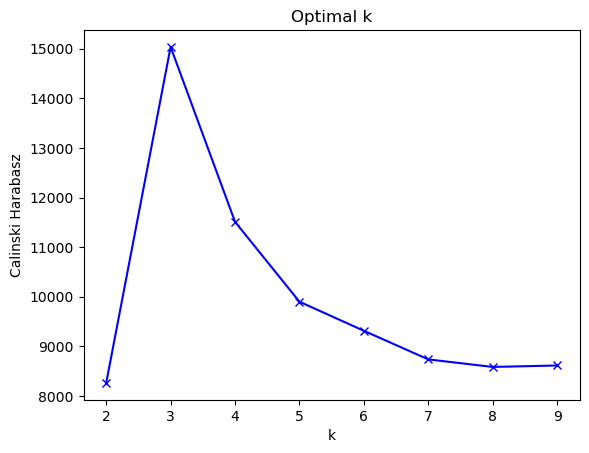

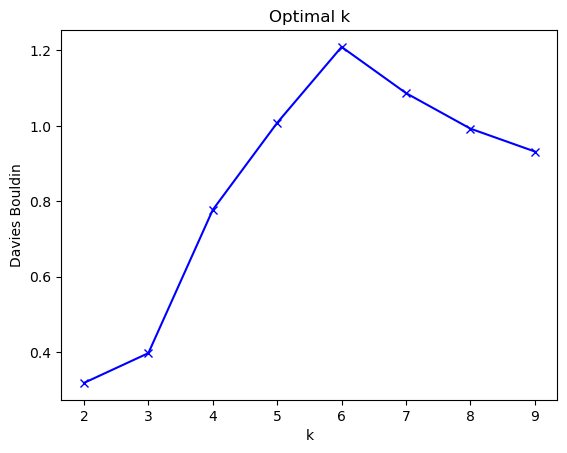

In [8]:
metrics_plots(max_k=10)

### Metoda Mini Batch <a name="mbkmeans"></a>
Modyfikacja popularnego algorytm klastrowania k-Mean. W efekcie często otrzymujemy lepsze podziały na klastry oraz charakteryzuje się szybszym czasem działania.
patrz: https://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf (Sculley2010)

#### Rozmiar próbki 
W tradycyjnym algorytmie K-Means, każda iteracja obejmuje wszystkie punkty danych w zestawie. W Mini-Batch K-Means, każda iteracja obejmuje tylko małą losową próbkę (tzw. mini-batch) z całego zestawu danych.

#### Szybkość
Dzięki użyciu mniejszych próbek danych, Mini-Batch K-Means jest zazwyczaj znacznie szybszy od standardowego K-Means, szczególnie dla dużych zestawów danych.

#### Jakość klasteryzacji
Chociaż Mini-Batch K-Means jest szybszy, może nie osiągnąć tak dobrej jakości klasteryzacji jak standardowy K-Means. To dlatego, że używa tylko podzbioru danych do aktualizacji centroidów klastrów, co może prowadzić do mniej precyzyjnych wyników.

#### Stabilność
Mini-Batch K-Means może być mniej stabilny niż standardowy K-Means, ponieważ wyniki mogą się różnić w zależności od wybranych mini-batchy. Jednakże, dla dużych zestawów danych, te różnice są zazwyczaj niewielkie.

#### Pamięć
Mini-Batch K-Means wymaga mniej pamięci, ponieważ nie musi przechowywać wszystkich punktów danych w pamięci na raz. To czyni go bardziej skalowalnym dla bardzo dużych zestawów danych.

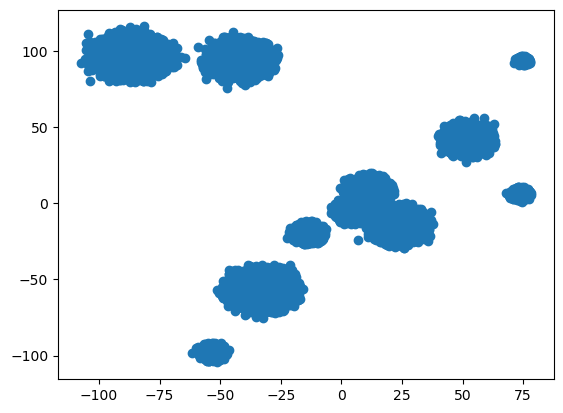

In [9]:
plt.scatter(X_batch_blobs[:,0], X_batch_blobs[:,1])
plt.show()

In [10]:
def _KMeans(X, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    return X, kmeans

def _MiniBatchKMeans(X, n_clusters):
    miniBatchKmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    miniBatchKmeans.fit(X)
    return X, miniBatchKmeans

Porównanie czasów działania:

In [11]:
%%time
for k in range(5):
    kmeans=_KMeans(X_batch_blobs, n_clusters=10)

C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\clust

CPU times: total: 1min 7s
Wall time: 3.46 s


In [12]:
%%time
for k in range(5):
    batch_kmeans=_MiniBatchKMeans(X_batch_blobs, n_clusters=10)

C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available 

CPU times: total: 19.8 s
Wall time: 1.44 s


In [13]:
def plot_clusters(X, model, title="", **kwargs):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np)
    else:
        y_pred = model.predict(X)
    plt.scatter(X[:,0],X[:,1],c=y_pred, cmap='viridis', **kwargs)
    plt.title(title)
    plt.show()

Wizualizacja podziału:

C:\Users\malys\AppData\Local\Temp\ipykernel_32668\1988933271.py:3: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = model.labels_.astype(np)


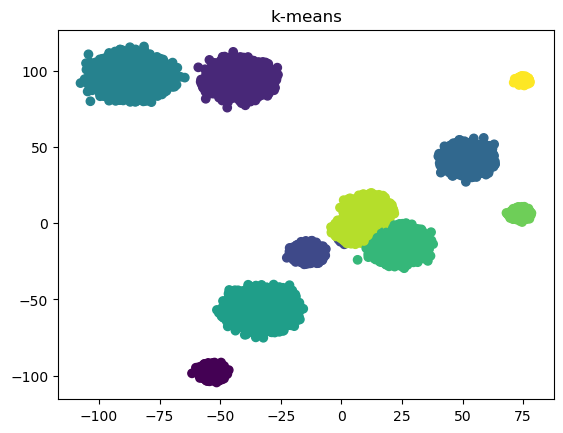

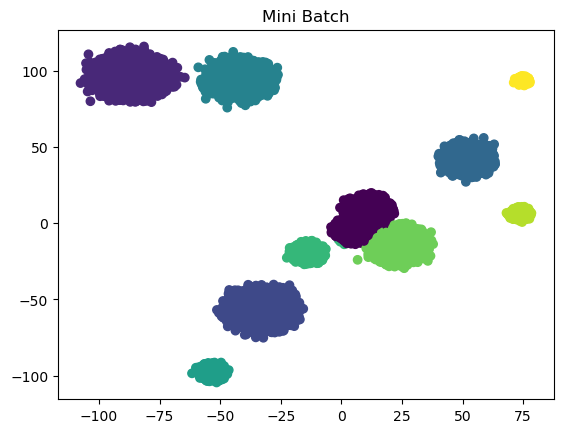

In [14]:
plot_clusters(title="k-means",*kmeans)
plot_clusters(title="Mini Batch",*batch_kmeans)

## DBSCAN  <a name="DBSCAN"></a>
### Density-based spatial clustering of applications with noise 

DBSCAN, to popularny algorytm grupowania oparty na gęstości. Jak nazwa wskazuje, metoda ta jest szczególnie przydatna do identyfikowania grup (klastrów) w danych, które mają gęstą koncentrację punktów w przestrzeni. W przeciwieństwie do algorytmów grupowania opartych na odległości, takich jak k-means, DBSCAN nie wymaga wcześniejszego określenia liczby klastrów i potrafi dobrze radzić sobie z kształtami klastrów, które nie są hiperkulami.

DBSCAN działa na podstawie dwóch kluczowych parametrów:

$\varepsilon$ (epsilon): to maksymalna odległość między dwoma próbkami, aby mogły być uważane za sąsiadów.
$\texttt{minPts}$: to minimalna liczba próbek w sąsiedztwie punktu, aby ten punkt mógł być uważany za centralny punkt gęstości.
Poniżej opisuję, jak działa DBSCAN:

   1. Znajdź punkty w sąsiedztwie ($\varepsilon$) każdego punktu, znajdź "punkty bazowe/rdzeniowe" (ang. core points) mające więcej niż $\texttt{minPts}$ sąsiadów.
   2. Znajdź spójne składowe punktów rdzeniowych, pomijając wszystkie pozostałe punkty,
   3. Przypisz każdy pozostały punkt do najbliższego klastra, jeśli jest w jego sąsiedztwie, w przeciwnym wypadku oznacz go jako szum/obserwację odstającą.

Ważną cechą DBSCAN jest to, że potrafi wykryć szum, czyli punkty danych, które nie pasują do żadnego klastra. To odróżnia DBSCAN od wielu innych technik grupowania.



<img src="https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg" alt="drawing" width="400"/>

Na powyższym diagramie $\texttt{minPts} = 4$. Punkt A oraz inne czerwone punkty są punktami bazowymi, ponieważ w ich obszarach rozmiaru $\varepsilon$ wokół nich znajdują się co najmniej 4 punkty (wliczając siebie). Ponieważ są one 'osiągalne' (ang. *reachable*) od siebie, tworzą pojedynczy klaster. Punkty B i C nie są punktami bazowymi, ale są osiągalne z punktu A (poprzez inne punkty bazowe) więc również należą do tego klastra. Punkt N jest obserwacją odstającą, ponieważ nie jest punktem bazowym ani nie jest bezpośrednio osiągalny z żadnego punktu bazowego.

Gdyby punkt N znajdował się w żółtym okręgu wokół punktu B ale poza czerwonymi okręgami, to nadal byłby obserwacją odstającą, gdyż nie można by było stworzyć do niego 'ścieżki' prowadzącej przez punkty bazowe. 

Źródło ilustracji: https://en.wikipedia.org/wiki/DBSCAN (Ester1996)

### Przykład <a name="DBSCAN_example"></a>

In [15]:
def _DBSCAN(X, eps=0.3):
    dbs = cluster.DBSCAN(eps=eps)
    dbs.fit(X)
    return X, dbs

Podstawowe parametry *sklearn.cluster.DBSCAN*: 

`eps` default=0.5  
`min_samples` default=5   
`metric` default = 'euclidean'  

C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\malys\AppData\Local\Temp\ipykernel_32668\1988933271.py:3: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = model.labels_.astype(np)


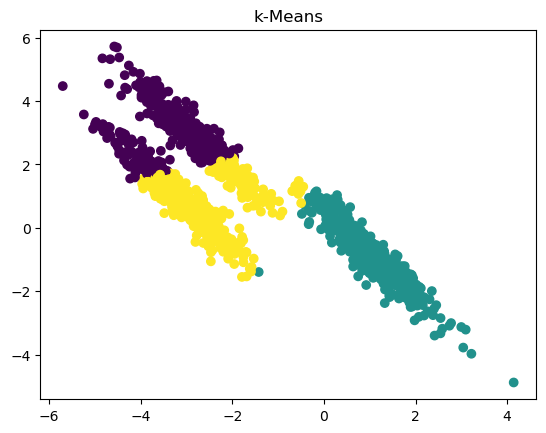

In [16]:
plot_clusters(title="k-Means", *_KMeans(X_aniso, n_clusters=3))

C:\Users\malys\AppData\Local\Temp\ipykernel_32668\1988933271.py:3: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = model.labels_.astype(np)


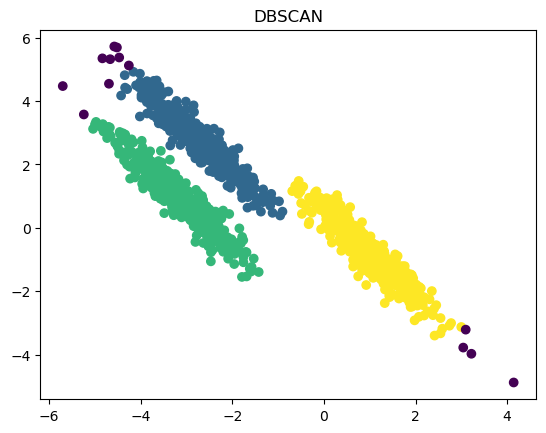

In [17]:
plot_clusters(*_DBSCAN(X_aniso, eps=0.3544), title="DBSCAN")

### Jak dobrać $\texttt{minPts}$ oraz $\varepsilon$?

Autorzy pracy wprowadzającej DBSCAN proponują następującą metodę wyboru odpowiednich wartości $\texttt{minPts}$ oraz $\varepsilon$:
1. Ustaw $\texttt{minPts}$ na podwojony wymiar danych (np. dla danych dwuwymiarowych $\texttt{minPts}=4$).
2. Dla każdego punktu oblicz odległość do $(\texttt{minPts} − 1)$ najbliższego sąsiada (różnego od ustalonego punktu).
3. Otrzymane odległości od największej i przedstaw na wykresie: na osi $x$ znajdują się numery punktów (po sortowaniu), a na osi $y$ odległości tych punktów od najbliższych sąsiadów.
4. Obserwacje po lewej stronie wykresu znajdują się daleko od swoich sąsiadów, więc można uznać że są odstające. Znajdź ostatni 'duży skok' (lub łokieć) na wykresie i wybierz wartość odległości jako $\varepsilon$. Obserwacje po lewej stronie tego skoku będą zaklasyfikowane jako odstające a na prawo trafią do klastrów. 


<img src="./wykres-db.png" alt="drawing" width="500"/>

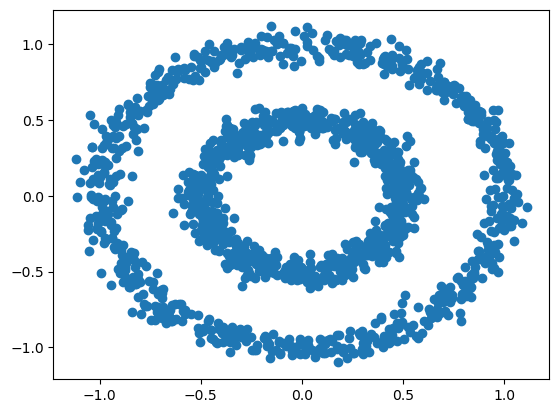

In [18]:
plt.scatter(noisy_circles[:, 0], noisy_circles[:, 1])

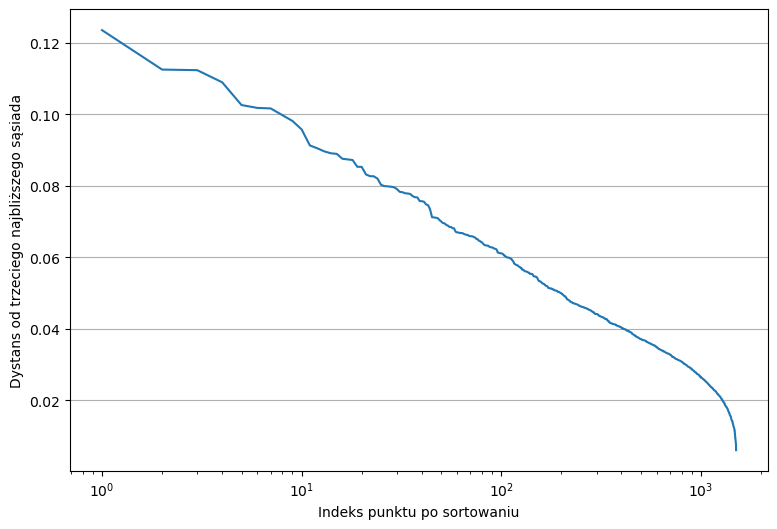

In [19]:
minPts = 4
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(noisy_circles)
distances, indices = nbrs.kneighbors(noisy_circles)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,noisy_circles.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

C:\Users\malys\AppData\Local\Temp\ipykernel_32668\1988933271.py:3: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = model.labels_.astype(np)


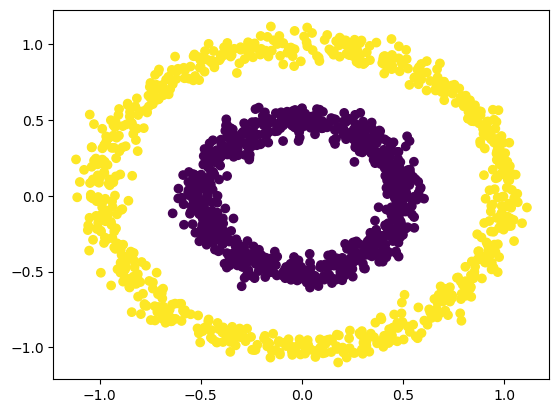

In [20]:
eps = 0.21

dbs = cluster.DBSCAN(eps=eps, min_samples=minPts)
dbs.fit(noisy_circles)

plot_clusters(noisy_circles, dbs)

## Zalety DBSCAN
1. Nie wymaga określenia liczby klastrów

W przeciwieństwie do k-means, DBSCAN automatycznie wykrywa liczbę klastrów na podstawie danych, co jest szczególnie przydatne w przypadku złożonych zbiorów danych.

3. Radzi sobie z punktami odstającymi

DBSCAN efektywnie identyfikuje i izoluje punkty odstające, które nie są częścią żadnego klastra.

4. Elastyczność w kształtach klastrów

Może identyfikować klastry o różnych, nieregularnych kształtach, które mogą być trudne do wykrycia za pomocą innych metod, takich jak k-means.

5. Mało parametrów

Główne parametry to eps (maksymalna odległość między sąsiednimi punktami) i min_samples (minimalna liczba punktów w sąsiedztwie, aby uznać punkt za centralny). Daje to stosunkowo prostą konfigurację.

6. Odporność na szum

Metoda jest naturalnie odporna na szum i punkty odstające, które są często pomijane podczas formowania klastrów.

## Wady DBSCAN
1. Wrażliwość na parametry

Wybór parametrów eps i min_samples może znacząco wpłynąć na wyniki klasteryzacji. Niewłaściwy wybór może prowadzić do utworzenia zbyt wielu małych klastrów lub połączenia różnych klastrów w jeden.


2. Problemy z różną gęstością klastrów

DBSCAN może nie działać dobrze, gdy klastry różnią się znacznie gęstością. Wysoko gęste klastry mogą być łączone z mniej gęstymi, co prowadzi do nieoptymalnych wyników.

3. Duża złożoność dla dużych zbiorów danych

Znalezienie odpowiednich sąsiadów dla każdego punktu w dużym zbiorze danych może być czasochłonne, zwłaszcza przy dużych wartościach eps.

4. Trudności w klastrowaniu danych o wysokiej wymiarowości

Duża liczba wymiarów zniekształcić odległości między punktami, co utrudnia efektywną klasteryzację za pomocą DBSCAN.

### Więcej <a name="DBSCAN_sources"></a>  

 - https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/DBScan_Clustering.ipynb

 - Przykład z dokumentacji: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
 
 - DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN (2017): https://dl.acm.org/doi/10.1145/3068335

## GMM (Gaussian Mixture Models) <a name="GMM"></a>

Jeszcze inne podejście oparte na modelowaniu skupień przy pomocy rozkładów normalnych.

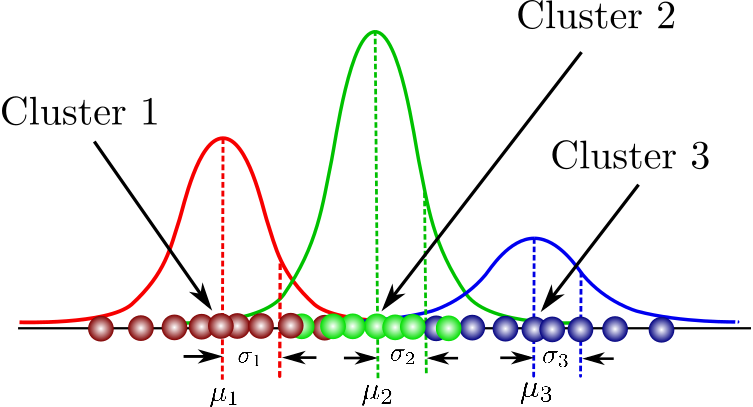

Źródło:https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

Dla **K** klastrów mamy **K** funkcji o 3 podstawowych parametrach:
 - $\mu$ - średnia określająca centrum,
 - $\Sigma$ - macierz kowariancji, określająca szerokość. W wielu wymiarach określa wymiary elipsoidy. 
 - $\pi$ - określa wysokość, $$\sum_{i}^{K}  \pi_{i} = 1$$
 
 $$p(x) = \sum_{i}^{K} \pi_{i} \mathcal{N}(\mu_{i}, \Sigma_{i})$$

W przeciwieństwie do pozostałych algorytmów zwraca prawdopodobieństwo przyporządkowania obserwacji do określonego skupienia.

## Zalety GMM

1. Modelowanie złożonych rozkładów

GMM są w stanie modelować dane o bardzo złożonych rozkładach, dzięki użyciu sumy rozkładów gaussowskich. Pozwala to na efektywne grupowanie danych o nieregularnych, nakładających się rozkładach.

2. Elastyczność w kształcie klastrów

W przeciwieństwie do k-means, który zakłada klastry o kształcie sferycznym, GMM mogą dopasowywać się do klastrów o różnych kształtach i rozmiarach, ponieważ każdy składnik mieszanki może posiadać własną macierz kowariancji.

3. Miękka przynależność do klastrów
GMM przypisują punktom dane prawdopodobieństwo przynależności do każdego klastra, co pozwala na bardziej subtelną interpretację niż twarda przynależność, jak w przypadku k-means.

Dobre oszacowanie parametrów

Algorytm EM (Expectation-Maximization), który jest używany do optymalizacji GMM, jest stosunkowo efektywny w znajdowaniu maksimum wiarygodności parametrów, nawet jeśli proces ten może zbiegać się do minimum lokalnego.

## Wady GMM

1. Złożoność obliczeniowa

Algorytm EM, który jest stosowany do dostosowania parametrów GMM, może być czasochłonny, szczególnie dla dużych zbiorów danych z wieloma wymiarami lub wieloma składnikami mieszanki.

2. Wrażliwość na wartości początkowe

Jak w wielu algorytmach optymalizacji, wyniki uzyskane za pomocą GMM mogą zależeć od wartości początkowych. Dobre inicjalizacje są kluczowe do osiągnięcia dobrych wyników.

3. Wybór liczby składników

Podobnie jak w innych metodach klasteryzacji, wybór liczby składników (klastrów) w mieszaninie ma znaczący wpływ na wyniki klasteryzacji. Nie istnieje uniwersalna metoda na ustalenie tej liczby, choć istnieją techniki takie jak kryterium informacyjne Akaikego (AIC) czy Bayesowskie kryterium informacyjne (BIC).

4. Problemy z wysoką wymiarowością danych

GMM może nie działać dobrze, gdy wymiarowość danych jest wysoka w stosunku do liczby próbek, co jest związane z trudnością w estymacji macierzy kowariancji, które mogą stać się osobliwe lub trudne do zinwertowania.

### Przykład <a name="GMM_example"></a>

In [21]:
data_varied = varied[0]

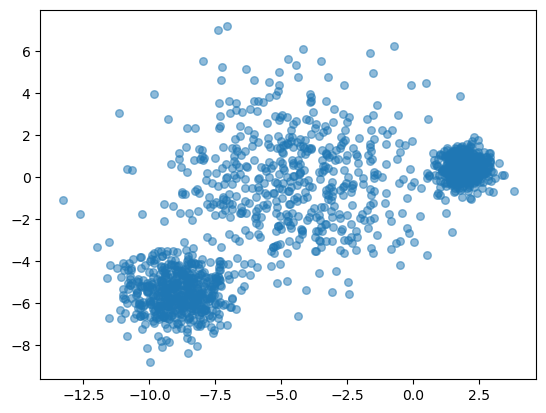

In [22]:
plt.scatter(data_varied[:,0], data_varied[:,1], alpha=0.5, s=30)
plt.show()

Jak sobie poradzi DBSCAN?

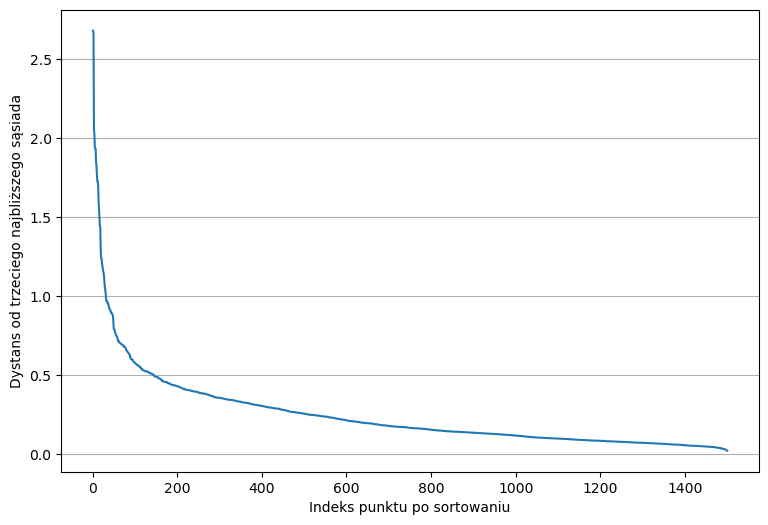

In [23]:
minPts = 4
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(data_varied)
distances, indices = nbrs.kneighbors(data_varied)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,data_varied.shape[0]+1)), distanceDec)

#plt.xscale('log')

plt.grid(axis='y')

plt.show()

C:\Users\malys\AppData\Local\Temp\ipykernel_32668\1988933271.py:3: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = model.labels_.astype(np)


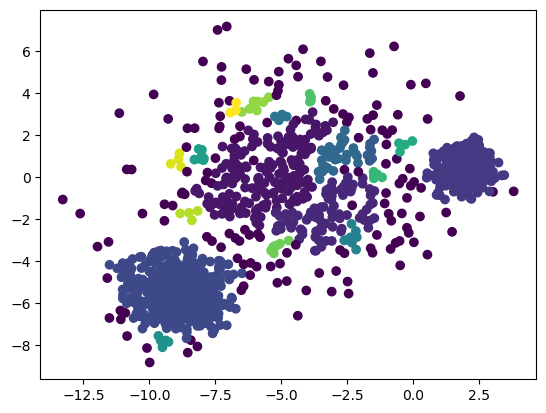

In [24]:
eps = 0.4

dbs = cluster.DBSCAN(eps=eps, min_samples=minPts)
dbs.fit(data_varied)

plot_clusters(data_varied, dbs)

Jak sobie poradzi KMeans?

C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\malys\AppData\Local\Temp\ipykernel_32668\1988933271.py:3: DeprecationWarning: in the future the `.dtype` attribute of a given datatype object must be a valid dtype instance. `data_type.dtype` may need to be coerced using `np.dtype(data_type.dtype)`. (Deprecated NumPy 1.20)
  y_pred = model.labels_.astype(np)


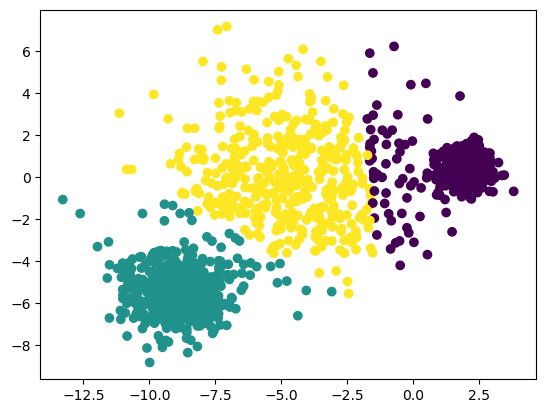

In [25]:
plot_clusters(*_KMeans(data_varied, n_clusters=3))

Jak sobie poradzi GMM?

In [26]:
def _GMM(X, n_components, covariance_type='full'):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    gmm.fit(X)
    return X, gmm

C:\Users\malys\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


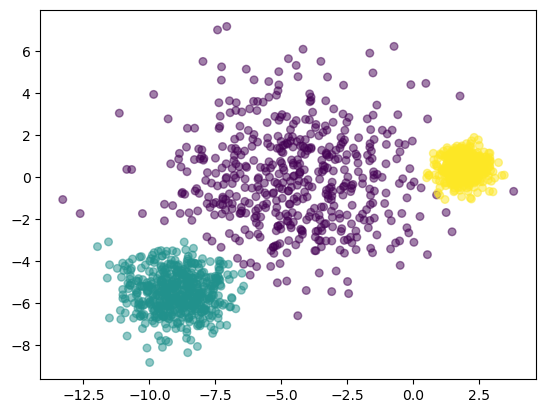

In [27]:
plot_clusters(*_GMM(data_varied, n_components=3), alpha=0.5, s=30)

### Zadania 

Przetestuj metody dla poniższych 3 zbiorów.

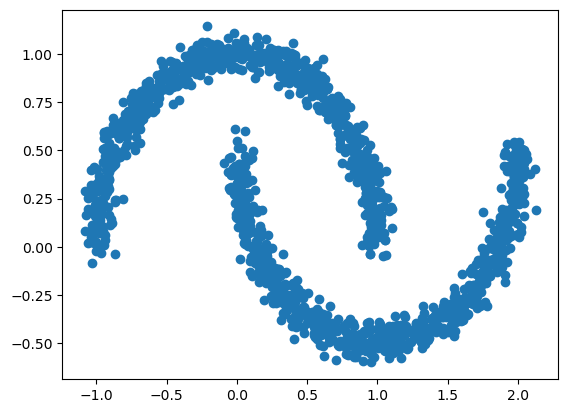

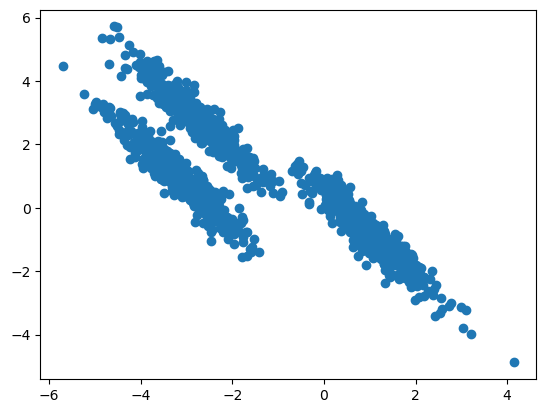

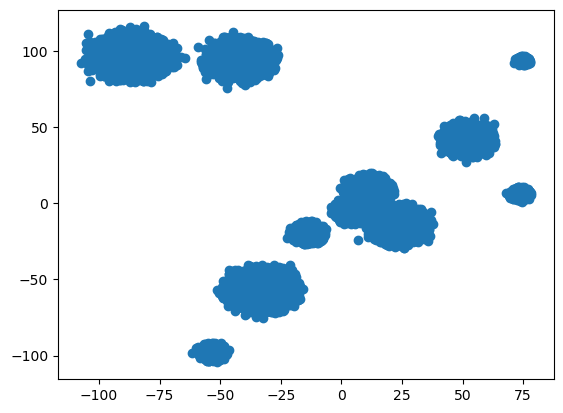

In [28]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1])
plt.show()
plt.scatter(aniso_noisy[0][:,0], aniso_noisy[0][:,1])
plt.show()
plt.scatter(X_batch_blobs[:,0], X_batch_blobs[:,1])
plt.show()

In [29]:
X = X_batch_blobs

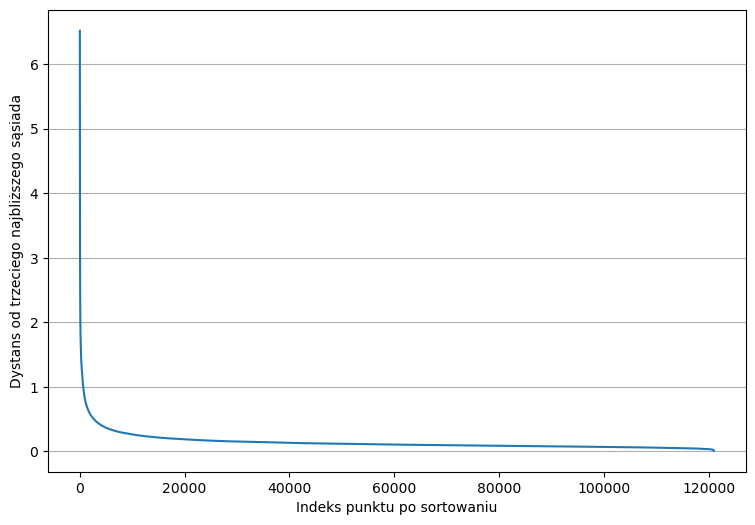

In [30]:
minPts = 4
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(X)
distances, indices = nbrs.kneighbors(X)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,X.shape[0]+1)), distanceDec)

#plt.xscale('log')

plt.grid(axis='y')

plt.show()

In [31]:
def plot_all_culsters(X, n_cluster, eps):
    plot_clusters(*_KMeans(X, n_clusters=n_cluster), title="k-Means")
    plot_clusters(*_MiniBatchKMeans(X, n_clusters=n_cluster), title="Mini Batch")
    plot_clusters(*_GMM(X, n_components=n_cluster), alpha=0.5, s=30, title="GMM")
    plot_clusters(*_DBSCAN(X, eps=eps), title="DBSCAN")

In [ ]:
plot_all_culsters(noisy_moons, n_cluster=2, eps=0.14)

In [ ]:
plot_all_culsters(aniso_noisy[0], n_cluster=3, eps=0.35)

In [ ]:
plot_all_culsters(X_batch_blobs, n_cluster=10, eps=5)

In [ ]:
path = "C:/Users/malys/Downloads/"
X = pd.read_csv(path + "urbanGB.csv", names=["x", "y"], header=None)
X = X.to_numpy()
X = X[np.random.randint(len(X), size=10000)]

In [ ]:
plot_all_culsters(X, n_cluster=10, eps=3)

In [2]:
#import gaussian_mixture library



NameError: name 'df_train_scaled_original' is not defined